In [91]:
#!curl https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

In [32]:
#!pipenv install seaborn 

In [265]:
#!pipenv install spacy

In [269]:
#!python -m spacy download en_core_web_sm


In [2]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
# import tqdm
from tqdm.auto import tqdm
#pd.set_option('display.max_colwidth', None)




## Step 1: Prepare documents (Extracting and Transforming)

## Ingestion
This was extracted from telegram channel conversation (from 14-2-2019 to 14-9-2024) on diet and the data was in form of many html documents.

In [106]:
# Load HTML files
def wrangle(paths):
    dfs=[]
    # forward fill after removed text from date column
    def clean_date(date):
                # Regular expression pattern for valid dates (e.g., '13 March 2019')
                pattern = r'^\d{1,2}\s\w+\s\d{4}$'  # Matches 'DD Month YYYY'
                if re.match(pattern, date):
                    return date
                else:
                    return None  # Replace invalid dates with None
    
    for html in paths:
        
        with open( html, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
    
            # Extract messages
            messages = []
            for message in soup.find_all('div', class_='message'):
                date = message.find('div', class_='body details').text.strip() if message.find('div', class_='body details') else None
                time = message.find('div', class_='date').text.strip() if message.find('div', class_='date') else None
                user = message.find('div', class_='from_name').text.strip() if message.find('div', class_='from_name') else None
                content = message.find('div', class_='text').text.strip() if message.find('div', class_='text') else None
                messages.append({"Date":date, "Time":time, "User": user,"Content": content})
            
            # Convert to DataFrame
            df = pd.DataFrame(messages)
            # fill in the na values by forward fill for dates
            df['Date']=df['Date'].ffill()
            # transform the date column by replacing any message about 'someone invited someone' in the group or removed someone with none
            df['Date']=df['Date'].apply(clean_date)
            df['Date']=df['Date'].ffill()
            # drop rows that have three nans. It is the date heading
            df=df.dropna(thresh=2)
            # forward fill user where nan
            df['User']=df['User'].ffill()
            # drop empty content it is usually pics
            df=df.dropna(subset='Content')
            dfs.append(df)
            print(df.head(1))
            
    return dfs

In [107]:
# file pattern
file_pattern=r'C:\Users\user\Documents\LLM Zoomcamp\Project\data\raw_data\messages*.html'

In [118]:
# Get a list of all matching files
files = glob.glob(file_pattern)  # we matched 438 files
len(files)
# for f in files:
#     print(f)

438

In [147]:
import time

t0 = time.time()
# Import html files using wrangle function, transform and combine them
#dfs=wrangle(files)
t1 = time.time()
total = t1-t0
# concat dataframes
#df=pd.concat(dfs, ignore_index=True)

df=df.dropna()
# Save to CSV
# df.to_csv('../data/clean_data/combo_conversations_latest.csv', index=False)
# df.isnull().sum()

In [148]:
print(total/60)

0.0


In [3]:
# import csv file
df = pd.read_csv('../data/clean_data/combo_conversations_latest.csv', parse_dates=['Date'])
#df.info()
df['Date']

0        2019-02-14
1        2019-02-14
2        2019-02-14
3        2019-02-14
4        2019-02-14
            ...    
414123   2021-04-28
414124   2021-04-28
414125   2021-04-28
414126   2021-04-28
414127   2021-04-28
Name: Date, Length: 414128, dtype: datetime64[ns]

In [4]:
df.head()

,Date,Time,User,Content
0,2019-02-14,08:02,Silmavi,Hello!
1,2019-02-14,08:05,Deleted Account,"sooo, detox finished when? 😄"
2,2019-02-14,08:05,Silmavi,Here we can talk about Aajonus?
3,2019-02-14,08:07,Deleted Account,Detox! Hell yeah Aajonus
4,2019-02-14,08:08,Silmavi,😂😂😂😂


In [5]:
# Set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)
# Sort the DataFrame by the index (Date) so that there is good flow in a chronological order.
df.sort_index(inplace=True)
df.tail()

,Time,User,Content
Date,,,
2024-09-14,03:15,Mziskaci,are wild animals safe to eat raw?
2024-09-14,01:16,Adrian Marquelos,I saw this on eat raw meat channel. I wouldn’t...
2024-09-14,00:31,Colby🐍,You got vaxxed even after listening to aajonus...
2024-09-14,08:00,Gabriel Olivares,Is it possible for a detox to last 4 months or...
2024-09-14,03:50,Marcel,What to do with 10L of raw milk that are alrea...


In [6]:
# slice the data and keep the last year only
df_slice = df.loc['2024-01-01':'2024-09-14', 'Content']
print(df_slice.info())
df_slice.head()



<class 'pandas.core.series.Series'>
DatetimeIndex: 44742 entries, 2024-01-01 to 2024-09-14
Series name: Content
Non-Null Count  Dtype 
--------------  ----- 
44742 non-null  object
dtypes: object(1)
memory usage: 699.1+ KB
None


Date
2024-01-01    this is the first I see an egg in bath ingredi...
2024-01-01                                             and egg?
2024-01-01    The plastic might even be better (especially i...
2024-01-01                                            Your love
2024-01-01    Better anything non processed.Sea water, an eg...
Name: Content, dtype: object

I decided to chunk any question with its answers together in a chunk

In [7]:
# create new variables

chunked_data = []
current_chunk = []
question_found = False

for i in range(len(df_slice)):
    message = df.iloc[i]['Content']
    
    # Check if the message is a question
    if message.endswith('?'):
        # If there's already a chunk being built (a question and its answers), finalize it
        if current_chunk:
            chunked_data.append(" ".join(current_chunk))
        # Start a new chunk with the current question
        current_chunk = [message]
        question_found = True
    else:
        # If the message isn't a question, but a question has been found, add it as an answer
        if question_found:
            current_chunk.append(message)
        # If no question has been found yet, skip this message or handle it as needed
        # (e.g., you could append it to the previous chunk if desired)

# Append the last chunk after the loop, if it exists
if current_chunk:
    chunked_data.append(" ".join(current_chunk))

# Create a new DataFrame with the chunked data
chunked_QandA = pd.DataFrame({'Chunked_Content': chunked_data})

# Save the chunked data to a CSV file
chunked_QandA.to_csv('../data/clean_data/question_answer_chunked_conversations.csv', index=False)


In [8]:
# function for splitting each chunk into sentences
# Function to split text into sentences
def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences


In [9]:
# load data
chunked_QandA=pd.read_csv('../data/clean_data/question_answer_chunked_conversations.csv')
# Count the numbers of sentences per row
chunked_QandA['number of sentences']=[len(x) for x in chunked_QandA['Chunked_Content'].apply(split_into_sentences)]
chunked_QandA['number of words']=[len(x.split()) for x in chunked_QandA['Chunked_Content']]
# get all information about the spread of the number of sentences
chunked_QandA['number of sentences'].describe()  # mean is 5 sentences
#chunked_QandA.sort_values(by=['number of sentences'], ascending=False)


count    5646.000000
mean        5.407014
std         5.790385
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        93.000000
Name: number of sentences, dtype: float64

In [10]:
chunked_QandA['number of words'].describe()

count    5646.000000
mean       92.178356
std       118.038356
min         1.000000
25%        19.000000
50%        53.000000
75%       120.000000
max      1852.000000
Name: number of words, dtype: float64

In [11]:
chunked_QandA[chunked_QandA['number of sentences']==2]

,Chunked_Content,number of sentences,number of words
0,when you eat it alone? Good idea to eat it onc...,2,69
3,"So guys, water=bad? I have dry skin even if i ...",2,14
7,what is aajonos saying about fasting? Not to lol,2,9
9,Cheese and honey btw meals? Sounds good Just c...,2,80
10,How you make it? Just put the milk in glass ja...,2,40
...,...,...,...
5632,What is this a religion ? That’s just one pers...,2,11
5635,What kind of argument is that ? 🔥=🧯,2,8
5642,"Are you ""discreet"" from discord? https://www.y...",2,20
5643,How is it gonna ferment if there aren't any ba...,2,18


### Compare the three methods:
- Taking the raw conversations was not the best option as each chunk was too short to get context
- Threaded chunks by grouping each user speech would less context and would not link each question to its relevant answer
- Grouping questions with their answer was the best option since the aim was for this to be health adviser.

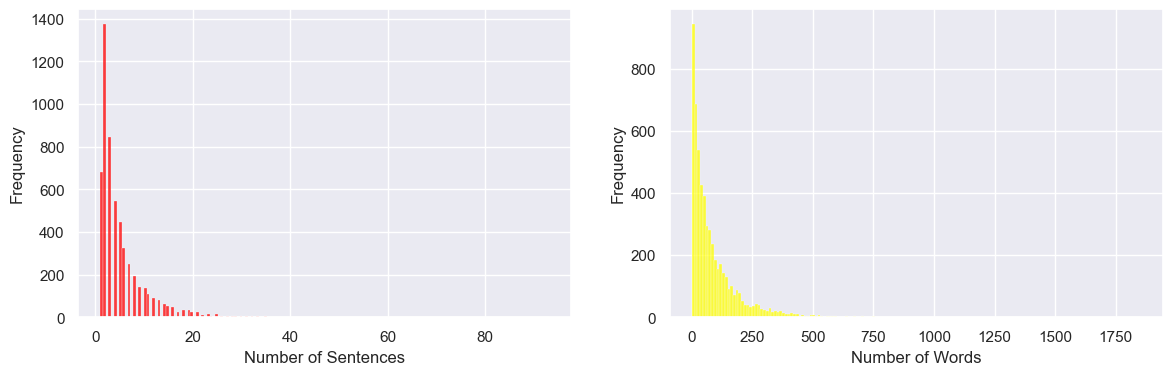

In [12]:
# number of sentences and words per chunk
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(data=chunked_QandA, x='number of sentences',color="red", ax=axs[0])
sns.histplot(data=chunked_QandA, x='number of words',color='yellow', ax=axs[1])
# # Adding labels and legend
# Set label for x-axis 
axs[0].set_xlabel( "Number of Sentences" , size = 12 ) 
axs[1].set_xlabel( "Number of Words" , size = 12 ) 
# Set label for y-axis 
axs[0].set_ylabel( "Frequency" , size = 12 ) 
axs[1].set_ylabel( "Frequency" , size = 12 ) 
  

# Display figure 
plt.show() 



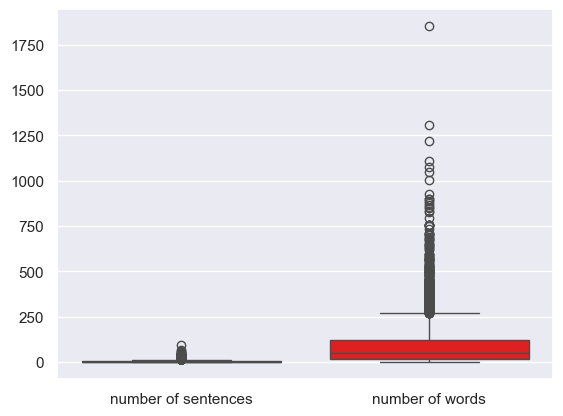

In [13]:
#sns.boxplot(data=chunked_QandA, x='number of sentences')
sns.boxplot(data=chunked_QandA[['number of sentences', 'number of words']],color="red")
# Display the plot
plt.show()

#### Amending the chunk sizes
This is important because different has limit of number of token it can handle
Model Context Window: Most transformer-based models, like GPT-3, have a context window that limits the number of tokens (words, punctuation marks, etc.)
they can process at once. For example, GPT-3 has a context window of around 4,000 tokens, 
while smaller models like GPT-2 might have around 1,024 tokens.
Comparison between using
sentences = re.split(r'(?<=[.!?]) +', text)  this one broken sentences if there was a punctuation and one or more spaces after
or sentences = re.split(r'(?<=[.!?])\s*', text) this one broke sentence where there was only one of the punctuation marks with or without spaces after.
I decided to choose the first method because the second method was one word quotes as two senteces. For examples 'How?' was counted as two sentences.
'I said.....' was counted as few sentences. Now min number of sentences will be 3 and maximum will be 50.

In [14]:
# examine the longest sentence
with pd.option_context('display.max_colwidth', None):
  display(chunked_QandA[chunked_QandA['number of sentences']==93][['Chunked_Content', 'number of words']])

Chunked_Content  \
3853  What do you mean "find raw kefir" ? It may not work for everyone. I couldn't get fasting to work long ago. But as I grew older and embraced spirituality, fasting worked well. So there's something beyond the physical at work here. Buy Organic eggs and eat alot raw (15-20 a day). You can buy kefir grains to ferment the milk or add raw honey to it and let it sit for 2-3 hours in room temp. If you drink 2 -3 liters of milk a day with some beef fat  then you don't really need butter that much. Beef fat > butter imo Here is some recommendations what you can eat haku bro you received so much good advice already. I had headaches all my life. Had amalgam fillings in all my large teeth, poor diet usually, many vaccines. My head has been detoxing a lot on raw primal. I don't get headaches anymore. I've been eating raw sour cream like crazy the last year - sometimes up to 5-7L per week. With honey and fruit and naturally sparkling mineral water. Raw fatty fish also one of my favourites. Plus sleeping when sleepy and warm baths when you feel like it Horrid All kefir grains are bs. If you add kefir grains to milk, it will ferment, but you won't have any probiotics because such bacterial cultures are opportunistic (they break food and feed only themselves instead of feeding human body). Here you can find abit of info about it. I supressed that part because i can only find raw kefir :P . You could starve more get unbearable headaches and learn that fasting is not good.When the body has no fats to encase toxins they start to cause damage and pain. Or maybe you could find good pork Well for me it was vice versa, only if i would supply my body enough fats,minerals, vitamins and enzymes the massive pain would disappear and i would go  back to sleep.  I don't understand how forcing your body to eat it self is beneficial especially with all the pollution around. When you would fast your body was thin, or fat, or in the middle ? You are forcing your body to use its emergency storage. Hehe, look whos here, familiar face ;) Just eat raw, like veg juices, milk, or meat. No cooked food as it clogs you up straight after a fast. Aajonus advocated losing weight rapidly instead of fasting. Yes the weight gain and weight loss cycle works too, at the physical level to remove toxins. But total lack of food causes some meta level of change in the body. In spite of fasting, i woukd do an egg fast I live in Amsterdam and you can only buy raw kefir in stores not raw milk. You'll have to go to farms to buy raw milk And it gets easier and easier as you go by, Sometimes my appetite is not that great or really no appetite at all so i just drink some milk with honey and eggs. That is equivalent of fasting for me. Sorry that was meant for haku 144 Members haha You start eating yourself and you feel good temporarily while body has a lot more job to do.My experience with fasting is just negative. I lose a lot of clarity. The whole think why i went and tried fasting in the first place was because i did not like eating. I used to never eat breakfast too. And the amount i ate was little I am familiar with Aajonus' view. It was only when I got so sick that I had to try fasting, and it certainly helped me alot. Raw alone can be too slow if you have serious problems. At least for me. How did it help you ? I see some part of people suggesting to fast too in other websites. I am certainty not going to force myself to starve. As i lose a lot of things when i do not eat.I had big teeth problems and if i starved i would have lost the teeth, because i was recommended to fast, but i followed Aajonus advice and it worked You should not fast in the first place There were many occasions. I have a penchant for getting into trouble. I had an electrocution problem where my nerves were on fire and I could sleep only every few days. Raw did not help. Lack of regenerative sleep slowly eats away at you. I had to solve the problem fast and only fasting worked. Follow Jes

In [15]:
# examine the chunk with highest number of words
with pd.option_context('display.max_colwidth', None):
  display(chunked_QandA[chunked_QandA['number of words']==3512][['Chunked_Content','number of sentences']])

,Chunked_Content,number of sentences


### Most of the chunks are below  words each
I decided to have 3 sentences as the minimum and 50 sentences as the maximum per chunk

In [16]:
def split_large_chunks_by_sentences(text, min_sentences=3, max_sentences=50):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []

    for sentence in sentences:
        current_chunk.append(sentence)
        if len(current_chunk) >= max_sentences:
            chunks.append('. '.join(current_chunk))
            current_chunk = []

    # Add the last chunk
    if len(current_chunk) >= min_sentences:
        chunks.append('. '.join(current_chunk))
    
    # Handle the last chunk if it's below the minimum
    if current_chunk and len(current_chunk) < min_sentences:
        if chunks:
            chunks[-1] += '. ' + '. '.join(current_chunk)
        else:
            chunks.append('. '.join(current_chunk))
    
    return chunks

# applying the funtion to our dataframe
df = chunked_QandA

split_chunks = []
for i, row in df.iterrows():
    text = row['Chunked_Content']
    split_chunks.extend(split_large_chunks_by_sentences(text, min_sentences=3, max_sentences=50))

# Create a new DataFrame with split chunks
split_df = pd.DataFrame({'Chunked_Content': split_chunks})

# Save the split data to a new CSV
split_df.to_csv('../data/clean_data/QandA_split_conversations.csv', index=False)
# Counting the number of sentences
split_df['number of sentences'] = [len(x) for x in split_df['Chunked_Content'].apply(split_into_sentences)]
max_sentences = split_df['number of sentences'].max()
min_sentences = split_df['number of sentences'].min()

print(f"Max sentences: {max_sentences}")
print(f"Min sentences: {min_sentences}")

# Counting the number of words
split_df['number of words'] = [len(x.split()) for x in split_df['Chunked_Content']]
max_sentences = split_df['number of words'].max()
min_sentences = split_df['number of words'].min()

print(f"Max words: {max_sentences}")
print(f"Min words: {min_sentences}")
print(len(split_df))
split_df['number of sentences'].value_counts()
split_df['number of words'].value_counts()

Max sentences: 52
Min sentences: 1
Max words: 1304
Min words: 1
5650


number of words
7      114
5      111
6      104
8       94
13      91
      ... 
332      1
375      1
322      1
712      1
442      1
Name: count, Length: 500, dtype: int64

In [17]:
split_df.reset_index(level=0, inplace=True) 
split_df.rename(columns={'index':'id'}, inplace=True)

In [18]:
split_df.to_csv('../data/clean_data/final_data_with_IDs_new.csv', index=False)

In [19]:
len(split_df)

5650

In [27]:
# create documents
documents =split_df.to_dict(orient='records')

In [29]:
documents[0]

{'id': 0,
 'Chunked_Content': "when you eat it alone?. Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks",
 'number of sentences': 2,
 'number of words': 69}

In [30]:
len(documents)

5650

## Step 2: Create Embeddings using Pretrained Models

In [49]:
import pickle

# save dictionary to person_data.pkl file
with open('vectorized_data.pkl', 'wb') as fp:
    pickle.dump(operations, fp)
    print('dictionary saved successfully to byte file')

dictionary saved successfully to byte file


In [50]:
import json

print("Started writing dictionary to a file")
with open("vectorized_data.json", "w") as fp:
    json.dump(operations, fp)  # encode dict into JSON
print("Done writing dict into .json file")

Started writing dictionary to a file
Done writing dict into .txt file


In [65]:
import json

print("Started writing dictionary to a file")
with open("vectorized_data.txt", "w") as fp:
    json.dump(operations, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Started writing dictionary to a file
Done writing dict into .txt file


In [75]:
# Read dictionary pkl file
with open('vectorized_data.pkl', 'rb') as fp:
    data= pickle.load(fp)
    print('Person dictionary')
    print(data[0:2])
#len(data)

Person dictionary
[{'Chunked_Content': "when you eat it alone? Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks", 'num of words': 69, 'text_vector': [0.010721932165324688, -0.04281805828213692, 0.026193972676992416, -0.04524363949894905, -0.06520701199769974, 0.004439320880919695, -0.032076478004455566, -0.03642812743782997, 0.08497369289398193, 0.023226218298077583, 0.025575537234544754, -0.025730609893798828, -0.0038772625848650932, -0.05311669781804085, 0.005834613926708698, 0.06900814175605774, -0.010103747248649597, 0.05677575618028641, -0.006016832776367664, 0.04230250418186188, -0.025512732565402985, -0.030057258903980255, -0.03446881100535393, 0.04153470695018768, 0.01937882974743843, -0.0226717684

In [56]:
# Open the file for reading
with open("vectorized_data.json", "r") as fp:
    # Load the dictionary from the file
    person_dict = json.load(fp)

# Print the contents of the dictionary
print(person_dict[0])

{'Chunked_Content': "when you eat it alone? Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks", 'num of words': 69, 'text_vector': [0.010721932165324688, -0.04281805828213692, 0.026193972676992416, -0.04524363949894905, -0.06520701199769974, 0.004439320880919695, -0.032076478004455566, -0.03642812743782997, 0.08497369289398193, 0.023226218298077583, 0.025575537234544754, -0.025730609893798828, -0.0038772625848650932, -0.05311669781804085, 0.005834613926708698, 0.06900814175605774, -0.010103747248649597, 0.05677575618028641, -0.006016832776367664, 0.04230250418186188, -0.025512732565402985, -0.030057258903980255, -0.03446881100535393, 0.04153470695018768, 0.01937882974743843, -0.022671768441796303, -0.030883

In [26]:
from openai import OpenAI


In [27]:
client = OpenAI()


In [28]:
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{"role": "user", "content": q}]
)

response.choices[0].message.content

"Vegetable oil is a common cooking fat made from plant sources, and its healthfulness can depend on several factors, including the type of oil, how it's processed, and how it’s used in your diet.\n\n### Pros of Vegetable Oil:\n1. **Unsaturated Fats**: Many vegetable oils, such as olive oil and canola oil, are high in unsaturated fats, which are considered healthier fats that can help reduce bad cholesterol levels.\n2. **Nutrients**: Some oils are rich in essential fatty acids and other nutrients (e.g., vitamin E in sunflower oil).\n3. **Versatility**: Vegetable oils can be used for various cooking methods and have a relatively high smoke point, making them suitable for frying and baking.\n\n### Cons of Vegetable Oil:\n1. **Omega-6 Fatty Acids**: While vegetable oils often contain polyunsaturated fats, they can also be high in omega-6 fatty acids. Excessive omega-6 intake, particularly when not balanced with omega-3 fatty acids, may promote inflammation.\n2. **Processing**: Many vegetab

In [ ]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5
    )

    return results

In [ ]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [ ]:
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

## Step 5: Add documents into index

In [70]:
for doc in tqdm(operations):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6800/6800 [08:21<00:00, 13.55it/s]


## Step 6: Create end user query

In [87]:
search_term = "is eating meat healthy?"
vector_search_term = model.encode(search_term)

In [88]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [89]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'diet-questions',
  '_id': 'Tk1Q_ZEB-BYxbY86ujWK',
  '_score': 0.8274733,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': 'M01L_ZEB-BYxbY86JSI8',
  '_score': 0.82315207,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': 'Xk1N_ZEB-BYxbY86zyuC',
  '_score': 0.8134525,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': '9U1S_ZEB-BYxbY86lDsM',
  '_score': 0.81185174,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': '401P_ZEB-BYxbY86tjHW',
  '_score': 0.8058151,
  '_source': {}}]

## Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [90]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [91]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"User": "Silmavi"},
    },
    knn=knn_query,
    size=5
)

In [92]:
response["hits"]["hits"]

[{'_index': 'diet-questions',
  '_id': 'y01L_ZEB-BYxbY86CCGL',
  '_score': 3.7038417,
  '_source': {'Date': '2019-02-24T00:00:00',
   'User': 'Silmavi',
   'Content': 'really😁🤨🤨🤨',
   'text_vector': [-0.010448154993355274,
    0.04629620537161827,
    0.007511643692851067,
    0.022471485659480095,
    0.032183099538087845,
    0.032937824726104736,
    -0.05606511980295181,
    0.04334476590156555,
    0.008313382975757122,
    0.0069734156131744385,
    0.03444882482290268,
    0.020371366292238235,
    -0.024321354925632477,
    0.02770829387009144,
    -0.021856702864170074,
    -0.015297445468604565,
    -0.024510452523827553,
    -0.0041328854858875275,
    0.028379207476973534,
    0.003877934068441391,
    0.035581305623054504,
    0.0342014916241169,
    -0.008496076799929142,
    -0.06302068382501602,
    -0.02258117124438286,
    -0.02990863472223282,
    -0.01822284609079361,
    -0.04249770939350128,
    0.06586158275604248,
    -0.03832273930311203,
    0.0016958988271653

In [282]:
split_df

,Chunked_Content,number of sentences,number of words
0,when you eat it alone?. Good idea to eat it on...,2,69
1,So they ate clay?. Act Charcoal will do the jo...,5,34
2,So when you have enough fat you feel nausea if...,1,13
3,"So guys, water=bad?. I have dry skin even if i...",2,14
4,@ubeats1 could you please advice any source/bo...,8,110
...,...,...,...
49001,are wild animals safe to eat raw?,1,7
49002,I saw this on eat raw meat channel.. I wouldn’...,3,41
49003,You got vaxxed even after listening to aajonus...,1,12
49004,Is it possible for a detox to last 4 months or...,1,26
